# Notebook para Comparar LLMs (noRAG) vs LLMs con RAG

## Instalar e Importar Librerias

In [122]:
# Instalar Librerias para Experimentación

!pip install -q markdown langchain openai ragas datasets "huggingface_hub[inference]" \
                  llama-index-embeddings-huggingface llama-index-embeddings-instructor \
                  sentence-transformers llama-index text_generation \
                  llama-index-llms-vllm llama-index-llms-huggingface \
                  llama-index-embeddings-azure-openai llama-index-llms-azure-openai \
                  llama-index-llms-openai-like llama-index-embeddings-langchain \
                  llama-index-llms-langchain

In [123]:
## Importación de librerías
import os
import logging
import sys
from typing import List, Optional
import pandas as pd
import nest_asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### AzureOpenAI Libs
from openai import AzureOpenAI
from google.colab import drive

### AzureOpenAI Langchain
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate

### Datasets from HuggingFaceDatasets
from datasets import load_dataset

## Llama Index
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate, Document
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.vllm import VllmServer
from llama_index.core.llms import ChatMessage

## Dataset y Preprocesado



#### Amnesty QA dataset

Este conjunto de datos contiene las siguientes columnas

* question: list[str] - Estas son las preguntas sobre las que se evaluará la pipeline RAG.

* context: list[list[str]] - Los contextos que utilizaremos con el LLM para responder la pregunta.

* ground_truth: list[str] -  La respuesta verdadera a las preguntas.


In [125]:
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2")
amnesty_qa

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for explodinggradients/amnesty_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/explodinggradients/amnesty_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    eval: Dataset({
        features: ['question', 'ground_truth', 'answer', 'contexts'],
        num_rows: 20
    })
})

In [126]:
### Cargar los datos de la libreria AmnestyQA y Preprocesar

## Preguntas
test_questions = amnesty_qa['eval']['question'][:20]
#print("Questions:")
#for question in test_questions:
#    print(question)

## Respuestas
test_answers = [[answer] for answer in amnesty_qa['eval']['answer'][:20]]
#print("\nAnswers:")
#for answer in test_answers:
#    print(answer)

## Contexto
doc_contexts = [[context] for context in amnesty_qa['eval']['contexts'][:20]]
print("\nContexts:")
for i, context in enumerate(doc_contexts):
    # Display only the first 300 characters of each context for brevity
    preview = context[0][:300] + '...' if len(context[0]) > 300 else context[0]
    print(f"Context {i+1}: {preview}")

# Escribirlo en disco para poder cargar el contexto para el LLM + RAG
with open('context.txt', 'w', encoding='utf-8') as file:
    for context in doc_contexts:
        if isinstance(context[0], list):  # Check if the context is a list of strings
            context_string = ' '.join(context[0])
        else:
            context_string = context[0]
        file.write(context_string + '\n')



Contexts:
Context 1: ["- In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisprudence recognizing a constitutional right to abortion.\n- This decision has had a massive impact: one in three women and girls of reproductive age now live in states where abortion access is either totally or near-totally inaccessible.\n- The states with the most restrictive abortion laws have the weakest maternal health support, higher maternal death rates, and higher child poverty rates.\n- The USA Supreme Court ruling has also had impacts beyond national borders due to the geopolitical and cultural influence wielded by the USA globally and the aid it funds.\n- SRR organizations and activists across the world have expressed fear about the ruling laying the groundwork for anti-abortion legislative and policy attacks in other countries.\n- Advocates have also observed the ruling's impact on progressive law reform and the stalling of the adoption and enforcement of a

## LLM Endpoints - Azure OpenAI 3.5

[AzureChatOpenAI LlamaIndex Docs](https://docs.llamaindex.ai/en/stable/api_reference/llms/azure_openai/)

## LLM sin Arquitecturas RAG


In [128]:
from langchain.schema import HumanMessage
from langchain import PromptTemplate

# Define la plantilla de prompt
template = """
You are a knowledgeable assistant. Please provide a concise and clear answer to the following question:

{question}

Give one condensed answer.
"""

# Define la función para generar el prompt a partir de la plantilla
def create_prompt(question):
    return template.format(question=question)

# Define el mensaje humano utilizando la plantilla de prompt
question = "What are the global implications of the USA Supreme Court ruling on abortion?"
prompt = create_prompt(question)
msg = HumanMessage(content=prompt)

# Obtén la respuesta del modelo de Azure OpenAI
response = azure_model(messages=[msg])

# Imprime solo el contenido de la respuesta
print(response.content)


The USA Supreme Court ruling on abortion could have significant global implications for women's reproductive rights and access to safe and legal abortion.


In [129]:
from langchain.schema import HumanMessage

def generate_response_without_rag(llm, prompt):
    msg = HumanMessage(content=prompt)
    response = llm(messages=[msg])
    response_text = response.content  # Accede al contenido de la respuesta
    return response_text

def completion_to_prompt(prompt):
    return f"[INST] {prompt} Give one answer in one sentence [/INST]"

def split_response(response, max_length):
    words = response.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            lines.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word
    lines.append(current_line)
    return "\n".join(lines)

# Se asume que las preguntas se obtienen de amnesty_qa['eval']['question']
test_questions_norag = amnesty_qa['eval']['question'][:4]
test_answers_norag = amnesty_qa['eval']['answer'][:4]

responses_without_rag = []
for question in test_questions_norag:
    prompt = completion_to_prompt(question)
    response_no_rag = generate_response_without_rag(azure_model, prompt)
    split_response_no_rag = split_response(response_no_rag, max_length=80)
    responses_without_rag.append(split_response_no_rag)

# Mostrar y comparar los resultados
for i, question in enumerate(test_questions_norag):
    print(f"Prompt {i+1}: {question}")
    print(f"Response without RAG {i+1}: {responses_without_rag[i]}")
    print("="*50)


Prompt 1: What are the global implications of the USA Supreme Court ruling on abortion?
Response without RAG 1: The USA Supreme Court ruling on abortion could have global implications as it
may influence other countries' policies and attitudes towards abortion.
Prompt 2: Which companies are the main contributors to GHG emissions and their role in global warming according to the Carbon Majors database?
Response without RAG 2: The Carbon Majors database shows that 100 companies are responsible for 71% of
global GHG emissions since 1988, with fossil fuel producers being the top
contributors.
Prompt 3: Which private companies in the Americas are the largest GHG emitters according to the Carbon Majors database?
Response without RAG 3: ExxonMobil is the largest GHG emitter among private companies in the Americas
according to the Carbon Majors database.
Prompt 4: What action did Amnesty International urge its supporters to take in response to the killing of the Ogoni 9?
Response without RAG 4

## Con RAG

### Cargar Contexto

In [130]:
## Cargar los documentos con el contexto de las preguntas
reader = SimpleDirectoryReader("./",num_files_limit=30)
documents = reader.load_data()

print(documents)

[Document(id_='bd0750fd-6e3b-4718-aede-9000528149b1', embedding=None, metadata={'file_path': '/content/context.txt', 'file_name': 'context.txt', 'file_type': 'text/plain', 'file_size': 31913, 'creation_date': '2024-05-30', 'last_modified_date': '2024-05-30'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='- In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisprudence recognizing a constitutional right to abortion.\n- This decision has had a massive impact: one in three women and girls of reproductive age now live in states where abortion access is either totally or near-totally inaccessible.\n- The states with the most restrictive abortion laws have the weakest maternal health support, higher maternal death rate

### Embeddings Endpoint - AzureOpenAI Embeddings

In [131]:
## Definir el Embeddings a utilizar
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["embedding_deployment"],
    model=azure_configs["embedding_name"],
)

In [132]:
## Funciones para construir la arquitectura basada en RAG

nest_asyncio.apply()

def build_query_engine(llm):
    vector_index = VectorStoreIndex.from_documents(
        documents, llm=azure_model,
        embed_model=azure_embeddings,
    )

    query_engine = vector_index.as_query_engine(similarity_top_k=2)
    return query_engine

def generate_responses(query_engine, test_questions, test_answers):
  responses = [query_engine.query(q) for q in test_questions]

  answers = []
  contexts = []
  for r in responses:
    answers.append(r.response)
    contexts.append([c.node.get_content() for c in r.source_nodes])
  dataset_dict = {
        "question": test_questions,
        "answer": answers,
        "contexts": contexts,
  }
  if test_answers is not None:
      ground_truth = [' '.join(ans) if isinstance(ans, list) else ans for ans in test_answers]
      dataset_dict["ground_truth"] = ground_truth
  ds = Dataset.from_dict(dataset_dict)
  return ds

In [133]:
from llama_index.core import Settings

Settings.llm = azure_model
Settings.embed_model = azure_embeddings

query = "What are the global implications of the USA Supreme Court ruling on abortion?"
#query_engine = index.as_query_engine()
query_engine = build_query_engine(azure_model)
answer = query_engine.query(query)

print(answer.get_formatted_sources())
print("query was:", query)
print("answer was:", answer)

> Source (Doc id: e223b07b-d017-452c-9472-faddfbcbf5a4): What are the global implications of the USA Supreme Court ruling on abortion?, The global implica...

> Source (Doc id: 3a611549-e52a-44f5-9c11-30b194e826a5): - In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisp...
query was: What are the global implications of the USA Supreme Court ruling on abortion?
answer was: The USA Supreme Court ruling on abortion has led to limited or no access to abortion for one in three women and girls of reproductive age in states where abortion access is restricted. These states also have weaker maternal health support, higher maternal death rates, and higher child poverty rates. The ruling has also had an impact beyond national borders due to the USA's geopolitical and cultural influence globally, as organizations and activists worldwide are concerned that the ruling may inspire anti-abortion legislative and policy attacks in other countries. The ruling h

In [134]:
from llama_index.core import Settings

def split_response(response_text, max_length):
    words = response_text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            lines.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word
    lines.append(current_line)
    return "\n".join(lines)

def completion_to_prompt(prompt):
    return f"[INST] {prompt} Give one answer in one sentence [/INST]"

# Configurar el modelo y el motor de consulta
Settings.llm = azure_model
Settings.embed_model = azure_embeddings

# Se asume que las preguntas se obtienen de amnesty_qa['eval']['question']
test_questions_rag = amnesty_qa['eval']['question'][:3]
test_answers_rag = amnesty_qa['eval']['answer'][:3]

responses_with_rag = []
query_engine = build_query_engine(azure_model)

for question in test_questions_rag:
    prompt = completion_to_prompt(question)
    answer = query_engine.query(prompt)
    split_response_rag = split_response(answer.response, max_length=80)  # Asegúrate de que 'response' sea el atributo correcto
    sources = answer.get_formatted_sources()
    responses_with_rag.append((split_response_rag, sources))

# Mostrar y comparar los resultados
for i, question in enumerate(test_questions_rag):
    print(f"Prompt {i+1}: {question}")
    print(f"Response without RAG {i+1}: {responses_with_rag[i][0]}")
    print(f"Sources {i+1}: {responses_with_rag[i][1]}")
    print("="*50)


Prompt 1: What are the global implications of the USA Supreme Court ruling on abortion?
Response without RAG 1: The USA Supreme Court ruling on abortion has led to limited or no access to
abortion for one in three women and girls of reproductive age in states where
abortion access is restricted, and has had an impact beyond national borders due
to the USA's geopolitical and cultural influence globally.
Sources 1: > Source (Doc id: fd9cf53f-1aa2-4a0e-a927-804755b258c3): What are the global implications of the USA Supreme Court ruling on abortion?, The global implica...

> Source (Doc id: 5180ca03-6063-48ee-8583-255649fc2a6c): - In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisp...
Prompt 2: Which companies are the main contributors to GHG emissions and their role in global warming according to the Carbon Majors database?
Response without RAG 2: The main contributors to GHG emissions and their role in global warming
according to the Carbon Maj

## Evaluación con RAGAS de LLMs

## RAG Metrics

* **Fidelidad (Faithfulness)** - Mide la consistencia factual de la respuesta con el contexto basado en la pregunta.
* **Precisión del Contexto (Context_precision)** - Mide cuán relevante es el contexto recuperado para la pregunta, reflejando la calidad del pipeline de recuperación.

* **Relevancia de la Respuesta (Answer_relevancy)** - Mide cuán relevante es la respuesta para la pregunta.

* **Exhaustividad del Contexto (Context_recall)** -  Mide la capacidad del recuperador para obtener toda la información necesaria requerida para responder la pregunta.

In [205]:
## Métricas RAG

from ragas.metrics.critique import harmfulness
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
        context_precision,
        faithfulness,
        answer_correctness,
        answer_relevancy,
        context_recall,
        answer_similarity,
        context_relevancy,
        context_entity_recall
)

metrics = [
        faithfulness,
        answer_correctness,
        answer_similarity,
]

* **Retriever**: Ofrece precisión del contexto y cobertura del contexto, que miden el rendimiento de tu sistema de recuperación.

* **Generator (LLM)**: Proporciona fidelidad, que mide las alucinaciones, y relevancia de la respuesta, que mide cuán relevantes son las respuestas a la pregunta.

## Evaluación de Respuestas LLM sin RAG

In [147]:
from llama_index.core import Settings
import pandas as pd
from datasets import Dataset, Features, Sequence, Value

def generate_response_without_rag(llm, prompt):
    msg = HumanMessage(content=prompt)
    response = llm(messages=[msg])
    response_text = response.content  # Accede al contenido de la respuesta
    return response_text

def completion_to_prompt(prompt):
    return f"[INST] {prompt} Give one answer in one sentence [/INST]"

def split_response(response_text, max_length):
    words = response_text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            lines.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word
    lines.append(current_line)
    return "\n".join(lines)

# Configurar el modelo y el motor de consulta
Settings.llm = azure_model
Settings.embed_model = azure_embeddings

# Se asume que las preguntas, contextos y ground truths se obtienen de amnesty_qa['eval']
test_questions_norag = amnesty_qa['eval']['question'][:20]
doc_contexts = [context for context in amnesty_qa['eval']['contexts'][:20]]  # Ajustar la estructura de los contextos
ground_truth = amnesty_qa['eval']['ground_truth'][:20]

responses_without_rag = []

for question in test_questions_norag:
    prompt = completion_to_prompt(question)
    response_no_rag = generate_response_without_rag(azure_model, prompt)
    responses_without_rag.append(response_no_rag)  # Asegúrate de que 'response_no_rag' sea el contenido correcto

# Construir el nuevo conjunto de datos
data = {
    "question": test_questions_norag,
    "ground_truth": ground_truth,
    "answer": responses_without_rag,
    "contexts": doc_contexts
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Mostrar el DataFrame
print(df)

# Guardar el DataFrame en un archivo CSV (opcional)
df.to_csv("evaluated_dataset.csv", index=False)

# Crear el dataset de Hugging Face con la estructura adecuada
features = Features({
    "question": Value("string"),
    "ground_truth": Value("string"),
    "answer": Value("string"),
    "contexts": Sequence(Value("string"))
})

# Asegurar que la columna 'contexts' sea una lista de strings
df['contexts'] = df['contexts'].apply(lambda x: x if isinstance(x, list) else [x])

hf_dataset = Dataset.from_pandas(df, features=features)

# Mostrar el dataset
print(hf_dataset)

# Guardar el dataset en disco (opcional)
hf_dataset.save_to_disk("evaluated_dataset")


                                             question  \
0   What are the global implications of the USA Su...   
1   Which companies are the main contributors to G...   
2   Which private companies in the Americas are th...   
3   What action did Amnesty International urge its...   
4   What are the recommendations made by Amnesty I...   
5   Who are the target audience of the two books c...   
6   Which right guarantees access to comprehensive...   
7   Who has the right to be fully informed about h...   
8   When can individuals be found guilty under Art...   
9   When does the prosecution consider statements ...   
10  What factors have contributed to the decline o...   
11  What conditions designate wetlands as Ramsar s...   
12                      Where was COP15 held in 2022?   
13  What is the purpose of the agreement known as ...   
14  Who failed to explicitly recognize Indigenous ...   
15  What are the consequences of criminalizing abo...   
16  What responsibilities shoul

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [206]:
result_azure_openai_norag = evaluate(
    hf_dataset,
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings)

result_azure_openai_norag

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'faithfulness': 0.5917, 'answer_correctness': 0.6251, 'answer_similarity': 0.9441}

In [207]:
result_azure_openai_norag_df = result_azure_openai_norag.to_pandas()
result_azure_openai_norag_df.head()

,question,ground_truth,answer,contexts,faithfulness,answer_correctness,answer_similarity
0,What are the global implications of the USA Su...,The global implications of the USA Supreme Cou...,The USA Supreme Court ruling on abortion could...,"[- In 2022, the USA Supreme Court handed down ...",1.0,0.386825,0.947301
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, the m...",The Carbon Majors database reveals that 100 co...,"[In recent years, there has been increasing pr...",0.5,0.442293,0.912028
2,Which private companies in the Americas are th...,The largest private companies in the Americas ...,ExxonMobil is the largest GHG emitter among pr...,[The issue of greenhouse gas emissions has bec...,0.0,0.613179,0.952717
3,What action did Amnesty International urge its...,Amnesty International urged its supporters to ...,Amnesty International urged its supporters to ...,"[In the case of the Ogoni 9, Amnesty Internati...",0.0,0.799553,0.948211
4,What are the recommendations made by Amnesty I...,The recommendations made by Amnesty Internatio...,Amnesty International recommended that the Spe...,"[In recent years, Amnesty International has fo...",0.5,0.602540,0.910161


## Evaluación de respuestas de LLM con RAG

### Directamente del Dataset de Amnesty (no preprocesado)

In [148]:
amnesty_qa["eval"]

Dataset({
    features: ['question', 'ground_truth', 'answer', 'contexts'],
    num_rows: 20
})

In [208]:
from ragas import evaluate

result_azure_openai = evaluate(
    amnesty_qa["eval"],
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings)

result_azure_openai

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'faithfulness': 0.6784, 'answer_correctness': 0.7314, 'answer_similarity': 0.9506}

In [209]:
result_azure_openai_df = result_azure_openai.to_pandas()
result_azure_openai_df.head()

,question,ground_truth,answer,contexts,faithfulness,answer_correctness,answer_similarity
0,What are the global implications of the USA Su...,The global implications of the USA Supreme Cou...,The global implications of the USA Supreme Cou...,"[- In 2022, the USA Supreme Court handed down ...",0.866667,0.789811,0.959244
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, the m...","According to the Carbon Majors database, the m...","[In recent years, there has been increasing pr...",0.916667,0.475441,0.941763
2,Which private companies in the Americas are th...,The largest private companies in the Americas ...,"According to the Carbon Majors database, the l...",[The issue of greenhouse gas emissions has bec...,0.500000,0.614841,0.959363
3,What action did Amnesty International urge its...,Amnesty International urged its supporters to ...,Amnesty International urged its supporters to ...,"[In the case of the Ogoni 9, Amnesty Internati...",0.400000,0.731708,0.926831
4,What are the recommendations made by Amnesty I...,The recommendations made by Amnesty Internatio...,Amnesty International made several recommendat...,"[In recent years, Amnesty International has fo...",0.733333,0.911620,0.919207


### Preprocesando el Dataset de Amnesty con Respuestas de LLM + RAG

In [210]:
from llama_index.core import Settings
import pandas as pd
from datasets import Dataset, Features, Sequence, Value

def completion_to_prompt(prompt):
    return f"[INST] {prompt} Give one answer in one sentence [/INST]"

def split_response(response_text, max_length):
    words = response_text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            lines.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word
    lines.append(current_line)
    return "\n".join(lines)

# Configurar el modelo y el motor de consulta
Settings.llm = azure_model
Settings.embed_model = azure_embeddings

# Se asume que las preguntas, contextos y ground truths se obtienen de amnesty_qa['eval']
test_questions_rag = amnesty_qa['eval']['question'][:20]
doc_contexts = [context for context in amnesty_qa['eval']['contexts'][:20]]  # Ajustar la estructura de los contextos
ground_truth = amnesty_qa['eval']['ground_truth'][:20]

responses_with_rag = []

for question in test_questions_rag:
    prompt = completion_to_prompt(question)
    answer = query_engine.query(prompt)
    responses_with_rag.append(answer.response)  # Asegúrate de que 'response' sea el atributo correcto

# Construir el nuevo conjunto de datos
data_rag = {
    "question": test_questions_norag,
    "ground_truth": ground_truth,
    "answer": responses_without_rag,
    "contexts": doc_contexts
}

# Crear un DataFrame
df_rag = pd.DataFrame(data_rag)

# Mostrar el DataFrame
print(df_rag)

# Guardar el DataFrame en un archivo CSV (opcional)
df_rag.to_csv("evaluated_dataset_rag.csv", index=False)

# Crear el dataset de Hugging Face con la estructura adecuada
features_rag = Features({
    "question": Value("string"),
    "ground_truth": Value("string"),
    "answer": Value("string"),
    "contexts": Sequence(Value("string"))
})

# Asegurar que la columna 'contexts' sea una lista de strings
df_rag['contexts'] = df_rag['contexts'].apply(lambda x: x if isinstance(x, list) else [x])

hf_dataset_rag = Dataset.from_pandas(df_rag, features=features_rag)

# Mostrar el dataset
print(hf_dataset_rag)

# Guardar el dataset en disco (opcional)
hf_dataset_rag.save_to_disk("evaluated_dataset_rag")


                                             question  \
0   What are the global implications of the USA Su...   
1   Which companies are the main contributors to G...   
2   Which private companies in the Americas are th...   
3   What action did Amnesty International urge its...   
4   What are the recommendations made by Amnesty I...   
5   Who are the target audience of the two books c...   
6   Which right guarantees access to comprehensive...   
7   Who has the right to be fully informed about h...   
8   When can individuals be found guilty under Art...   
9   When does the prosecution consider statements ...   
10  What factors have contributed to the decline o...   
11  What conditions designate wetlands as Ramsar s...   
12                      Where was COP15 held in 2022?   
13  What is the purpose of the agreement known as ...   
14  Who failed to explicitly recognize Indigenous ...   
15  What are the consequences of criminalizing abo...   
16  What responsibilities shoul

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [211]:
query_engine1 = build_query_engine(azure_model)
result_ds = generate_responses(query_engine1, test_questions, test_answers)

In [212]:
result_azure_openai2 = evaluate(
    result_ds,
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings
)

result_azure_openai2

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'faithfulness': 0.9389, 'answer_correctness': 0.6372, 'answer_similarity': 0.9490}

In [213]:
result_azure_openai_df2 = result_azure_openai2.to_pandas()
result_azure_openai_df2.head()

,question,answer,contexts,ground_truth,faithfulness,answer_correctness,answer_similarity
0,What are the global implications of the USA Su...,The global implications of the USA Supreme Cou...,[What are the global implications of the USA S...,The global implications of the USA Supreme Cou...,1.000000,0.517590,0.959244
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, the m...",[What are the global implications of the USA S...,"According to the Carbon Majors database, the m...",1.000000,0.478402,0.945865
2,Which private companies in the Americas are th...,The private companies responsible for the most...,"[Additionally, between 2010 and 2020, human mo...","According to the Carbon Majors database, the l...",0.666667,0.792124,0.918494
3,What action did Amnesty International urge its...,Amnesty International urged its supporters to ...,[The organization also urged its members to ra...,Amnesty International urged its supporters to ...,1.000000,0.688957,0.955828
4,What are the recommendations made by Amnesty I...,Amnesty International recommended that the Spe...,[The organization also urged its members to ra...,Amnesty International made several recommendat...,1.000000,0.559712,0.941549


## Gráficas de Comparativa LLM vs LLM con RAG

In [215]:
import pandas as pd

results_df = pd.DataFrame({
    'Metric': ['Fidelidad', 'Corrección de la Respuesta', 'Similaridad Semántica de la Respuesta'],
    'LLM sin RAG': pd.Series(result_azure_openai_norag),
    'LLM con RAG': pd.Series(result_azure_openai2),
})

results_df.set_index('Metric', inplace=True)
print(results_df)

                                       LLM sin RAG  LLM con RAG
Metric                                                         
Fidelidad                                 0.591667     0.938889
Corrección de la Respuesta                0.625122     0.637225
Similaridad Semántica de la Respuesta     0.944117     0.949007


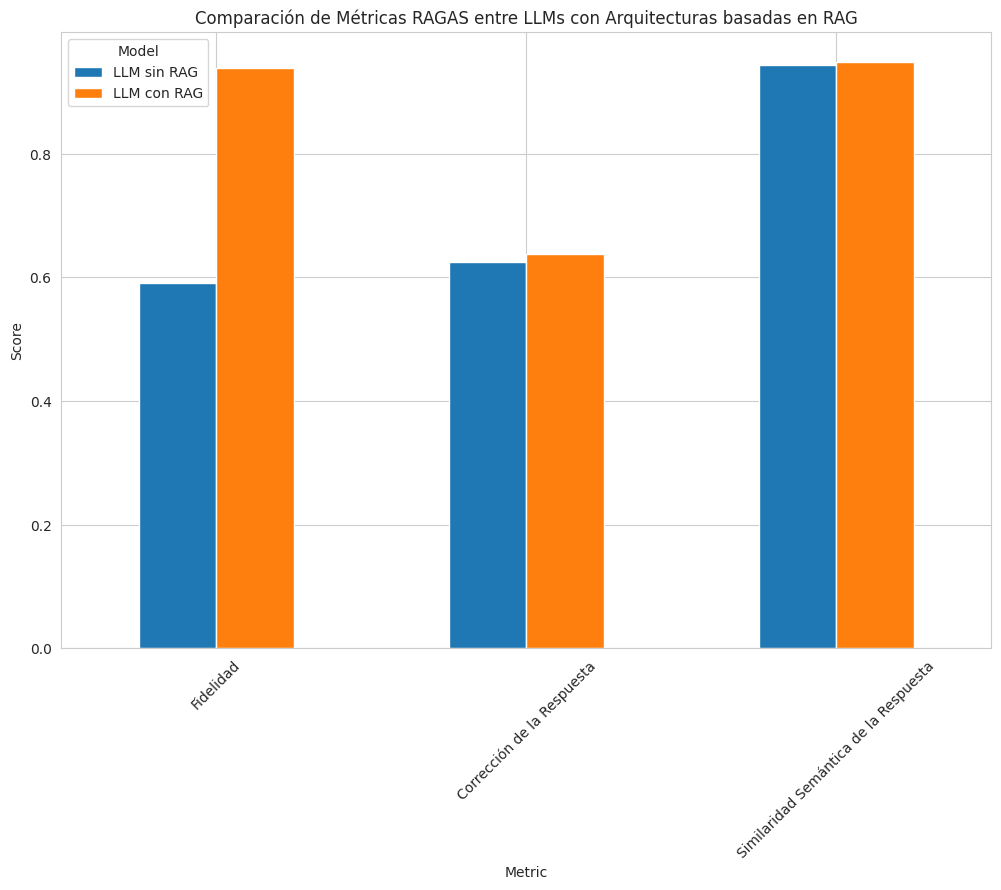

In [216]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de Métricas RAGAS entre LLMs con Arquitecturas basadas en RAG')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Model')
plt.show()

In [217]:
def analysis(result_azure_openai_norag, result_azure_openai):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, len(result_azure_openai_norag.columns), figsize=(12, 5))  # Assuming all DataFrames have the same columns

    # Iterate over the columns and plot the data for each model on each axis
    for i, col in enumerate(result_azure_openai_norag.columns):
        sns.kdeplot(data=result_azure_openai_norag[col].values, ax=axs[i], fill=True, label="LLM sin RAG")
        sns.kdeplot(data=result_azure_openai[col].values, ax=axs[i], fill=True, label="LLM con RAG")

        axs[i].set_title(f'Distribución de las puntuaciones de {col}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

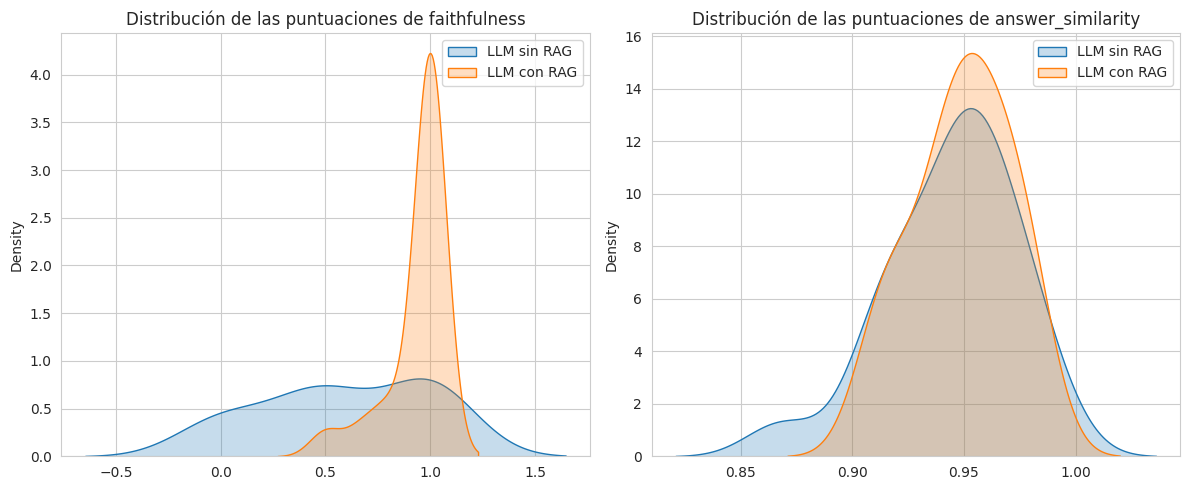

In [218]:
analysis(
    result_azure_openai_norag_df[['faithfulness', 'answer_similarity']],
    result_azure_openai_df2[['faithfulness', 'answer_similarity']],
)

In [221]:
import plotly.graph_objects as go

data_norag = {
    'faithfulness': result_azure_openai_norag['faithfulness'],
    'answer_correctness': result_azure_openai_norag['answer_correctness'],
}

data_rag = {
    'faithfulness': result_azure_openai['faithfulness'],
    'answer_correctness': result_azure_openai['answer_correctness'],
}

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=list(result_azure_openai_norag.values()),
    theta=list(result_azure_openai_norag.keys()),
    fill='toself',
    name='LLM sin RAG'
))

fig.add_trace(go.Scatterpolar(
    r=list(result_azure_openai2.values()),
    theta=list(result_azure_openai2.keys()),
    fill='toself',
    name='LLM con RAG'
))


fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title='Comparación entre LLM (sin RAG) vs LLM con RAG',
    width=800,
)

fig.show()
